# Calculating Rate of Turn (ROT)

As shown in the script below the ROT contained within the AIS data doesn't appear to be accurate. This code below uses
the latitiude and longitude to calculate a new rate of turn.

In [1]:
# base libraries
import numpy as np
import pandas as pd
import datetime
import matplotlib.pyplot as plt
import math 
import os
import json

In [2]:
# set variables from config file
config_path = os.path.abspath('..')

with open(config_path + '/config.json', 'r') as f:
    config = json.load(f)

processing_path = config['DEFAULT']['processing_path']
shipping_filename = config['DEFAULT']['shipping_filename']
shipping_rot_filename = config['DEFAULT']['shipping_rot_filename']

In [3]:
# import the shipping file generted in the data import script
# where the data from outside the port doesn't contain some information null values exist, it's therefore
# necessary to specify the data type when importing the full dataset
dtype_dic = {'MMSI':int,'dt':'str', 'lat':'float', 'long':'float','SOG':'float', 'ROT':'float', 
             'Type':'str', 'gross_tonnage':'float','vessel_name':'str', 'ETA':'str', 'POC_LOCODE':'str',
             'last_port_LOCODE':'str', 'next_port_LOCODE':'str', 'status':'str','voyage_id':'float','tripid':int,
            'in_hazmat':'str','out_hazmat':'str'}
parse_dates = ['dt', 'ETA']

shipping_data = pd.read_csv(processing_path + shipping_filename,header = 0,delimiter = ',',dtype = dtype_dic, parse_dates=parse_dates)

The histogram below of the rate of turn within the supplied AIS data suggests it's not accurate. A new ROT variable will be derived directly from the latitudinal and longitudinal points.

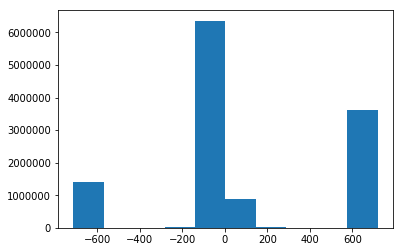

In [4]:
plt.hist(shipping_data['ROT'])
plt.show()

In [5]:
shipping_data = shipping_data.drop(['ROT'], axis=1)

### ROT

To calcuate the ROT three latitudinal / longitudinal pairs that describe positions on the sea at times t1, t2 and t3 are used. The ROT at t2 is given by firstly calculating the angle of turn at t2 using standard trigonometric techniques. This angle is then divided by the time taken to travel between t3 and t2 to give ROT. The two ship tracks below illustrate the differences between high and low ROT. 

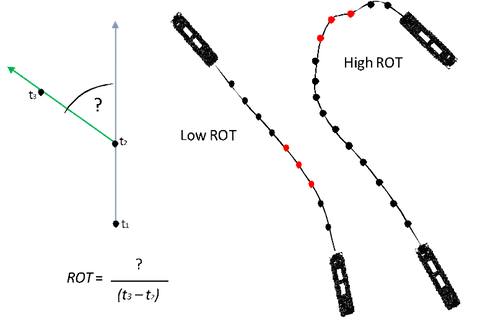

In order to calculate a rate of turn compared to the previous timepoint the longitudes must be unique (otherwise the angle will be 0). Note it's not possible to group by longitude as the ship may pass through the same longitude at a later stage in the voyage e.g. through turning, or as part of the outbound journey

In [6]:
def long_id(X):
    ''' 
    Adds a counter which increments if the value is greater than zero
    Parameters
      x: a series of values 
    Returns a series 
    '''

    y = list()

    for x in X:
        if np.isnan(x):
            counter = 1
        elif abs(x) > 0:
            counter += 1
        
        y.append(counter)

    return pd.Series(y, index = X.index)

In [7]:
# in order to reduce the data to unique longitudes the long_id function is applied to the difference between
# the previous longitude and the longitude and the current time point for each voyage (MMSI and tripid combination)
shipping_data['long_diff'] = shipping_data.groupby(['MMSI','tripid'])['long'].transform(lambda x: x.diff()) 
id_long = long_id(shipping_data['long_diff'])
shipping_data['longid'] = id_long

To reduce the data to unique longitudes the min of the latitudes and the time midpoint is calculated for each longitude id. As the latitudes and time points are so close a simple min is sufficient.

In [8]:
sd_lat_min = shipping_data.groupby(['MMSI','tripid','longid'], as_index = False)['lat'].min()
shipping_data = shipping_data.merge(sd_lat_min,on=['MMSI','tripid','longid','lat'])

Some duplicates still remain as the both the longitude and latitude are the same but the time point is different.

In [9]:
sd_dt_min = shipping_data.groupby(['MMSI','tripid','longid'], as_index = False)['dt'].min()
shipping_data = shipping_data.merge(sd_dt_min,on=['MMSI','tripid','longid','dt'])

### Calculating ROT

In [10]:
def calculate_bearing(pointA, pointB):
    """
    Calculates the bearing between two points using the formula
        θ = atan2(sin(Δlong).cos(lat2),
                  cos(lat1).sin(lat2) − sin(lat1).cos(lat2).cos(Δlong))
    Parameters
      pointA: latitude/longitude for the first point in decimal degrees
      pointB: latitude/longitude for the second point in decimal degrees
    Returns the bearing in degrees as a float
    """
    
    lat1 = math.radians(pointA[0])
    lat2 = math.radians(pointB[0])

    diffLong = math.radians(pointB[1] - pointA[1])

    x = math.sin(diffLong) * math.cos(lat2)
    y1 = math.cos(lat1) * math.sin(lat2)
    y2 = math.sin(lat1) * math.cos(lat2) * math.cos(diffLong)
    y = y1 - y2

    initial_bearing = math.atan2(x, y)

    initial_bearing = math.degrees(initial_bearing)
    compass_bearing = (initial_bearing + 360) % 360

    return compass_bearing

To use the function above it's necessary to have the previous dt, lat, and long on the same row as the data point the bearing is being calculated for

In [11]:
shipping_data['prev_dt'] = shipping_data.groupby(['MMSI','tripid'])['dt'].shift(-1)
shipping_data['prev_lat'] = shipping_data.groupby(['MMSI','tripid'])['lat'].shift(-1)
shipping_data['prev_long'] = shipping_data.groupby(['MMSI','tripid'])['long'].shift(-1)

In [12]:
shipping_data['bearing'] = shipping_data.apply(lambda row: calculate_bearing((row['prev_lat'],row['prev_long']),(row['lat'],row['long'])),axis=1)
# to apply the rot calculation the previous bearing should be on the same row as the bearing for 
# the current time point
shipping_data['prev_bearing'] = shipping_data.groupby(['MMSI','tripid'])['bearing'].shift(1)

The numerator of the ROT calculation at each timestamp is the difference between the bearing of the current timestamp and the previous timestamp.

The calculation for the difference between the bearing and the previous bearing needs to be absolute and take into account that an angle of 0 and 360 is the same

In [13]:
def bearing_diff(bearing, prev_bearing):
    
    """
    Calculates the absolute difference between two angles
    Parameters
      bearing: bearing in degrees of the first angle
      prev_bearing: bearing in degrees of the second angle
    Returns the difference in degrees as a float
    """

    # if bearing - prev_bearing <=180 then taking the absolute difference is correct
    if bearing - prev_bearing <= 180:
        bearing_diff = abs(bearing - prev_bearing)
    # otherwise if bearing is larger than previous_bearing the total difference is the prev_bearing plus the difference
    # between 360 and the bearing
    elif bearing > prev_bearing:
        bearing_diff = prev_bearing + (360 - bearing)
    # otherwise if prev_bearing is larger than bearing the total difference is the bearing plus the difference 
    # between 360 and the prev_bearing
    elif prev_bearing > bearing:
        bearing_diff = bearing + (360 - prev_bearing)
    # in all other cases take the absolute difference
    else:
        bearing_diff = abs(bearing - prev_bearing)

    return bearing_diff

In [14]:
shipping_data['bearing_diff'] = shipping_data.apply(lambda row: bearing_diff(row['bearing'],row['prev_bearing']),axis=1)

The denominator of the ROT calculation is the difference between the two timestamps in seconds. 

In [15]:
shipping_data['time_diff'] = shipping_data['prev_dt'].sub(shipping_data['dt'])

In [16]:
def time_convert(x):
    
    """
    Converts a timestamp into seconds, allowing for nat values
    Parameters
      x: a timestamp
    Returns seconds
    """

    try: 
        t = x.total_seconds()
    except:
        t = float('nan')

    return t

In [17]:
shipping_data['time_diff_secs'] = shipping_data.time_diff.apply(time_convert)

Calculate the ROT as the difference in the bearings divided by the difference in time

In [18]:
shipping_data['rot'] = shipping_data['bearing_diff'].div(pd.to_numeric(shipping_data['time_diff_secs']))

## Checking ROT

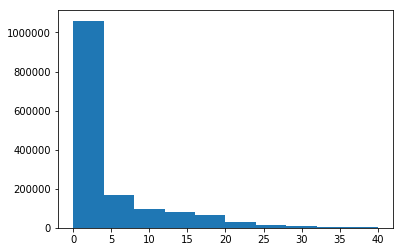

In [19]:
# as rot is taken as degrees of sec, significant manouvering relates to relatively small rot values
plt.hist(shipping_data['rot'][shipping_data['status'] == 'In Port'].dropna(),range = (0,40))
plt.show()

## Exporting Data

In [22]:
# drop unnecessary fields
shipping_data.drop(['long_diff','longid','prev_lat','prev_long','bearing','prev_bearing','time_diff',
                    'bearing_diff','time_diff_secs','prev_dt'],axis = 1,inplace=True)

In [23]:
shipping_data.to_csv(processing_path + shipping_rot_filename,header=True,index=False,sep=',')

In [25]:
shipping_data.describe().astype(int)

,MMSI,SOG,gross_tonnage,lat,long,voyage_id,tripid,rot
count,10762318,10762318,5502989,10762318,10762318,1540990,10762318,10735211
mean,277388894,14,35077,51,1,1085977,107,1
std,109002925,8,48065,0,0,37226,119,5
min,41491304,0,0,51,1,1001116,1,0
25%,235078345,8,2984,51,1,1056014,7,0
50%,235099364,15,16342,51,1,1087717,60,0
75%,246171000,23,53208,51,1,1115273,186,1
max,970013941,102,210000,51,1,1164010,693,359
